## Colab Setup

In [ ]:
from google.colab import drive
import os

# mount on drive
drive.mount('/content/drive/')
# go to project directory
os.chdir('/content/drive/MyDrive/activity-detection')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [95]:
# install requirements
# !pip install mediapipe==0.8.10 opencv_python_headless==4.1.2.30
!pip install mediapipe opencv_python imbalanced-learn eli5 shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Requirements

In [97]:
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import eli5
from glob import glob
import time
import gc
import pickle
# from imblearn.over_sampling import SMOTE

## Feature Extraction

### Pose Estimation Model and Transformation Functions

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def estimate_pose(image):
    # Setup mediapipe instance
    pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    # Recolor image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Make detection
    results = pose.process(image)

    # # Recolor back to BGR
    # image.flags.writeable = True
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # # Render detections
    # mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    #                             mp_drawing.DrawingSpec(
    #                                 color=(245, 117, 66), thickness=2, circle_radius=2),
    #                             mp_drawing.DrawingSpec(
    #                                 color=(245, 66, 230), thickness=2, circle_radius=2)
    #                             )
    # # Return output
    # cv2.imwrite('output.png', image)
    try:
        return results.pose_landmarks.landmark
    except AttributeError:
        return None


def calculate_angle(first, mid, end):
    first = np.array(first) 
    mid = np.array(mid)  # Mid
    end = np.array(end)  # End

    radians = np.arctan2(end[1]-mid[1], end[0]-mid[0]) - \
        np.arctan2(first[1]-mid[1], first[0]-mid[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

def calculate_all_angles(landmarks):
    angle_map = {
        'SHOULDER': ['ELBOW', 'SHOULDER', 'HIP'],
        'ELBOW': ['SHOULDER', 'ELBOW', 'WRIST'],
        'HIP': ['KNEE', 'HIP', 'SHOULDER'],
        'KNEE': ['HIP', 'KNEE', 'ANKLE'],
        'ANKLE': ['KNEE', 'ANKLE', 'PINKY']
    }
    
    angles = {}
    for angle_name, landmark_points in angle_map.items():
        for side in ['LEFT', 'RIGHT']:
            # get landmark names
            landmark_names = []
            for point in landmark_points:
                landmark_names.append(side+'_'+point)
            # calculate angle
            first = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[0]).value].x,
                     landmarks[getattr(mp_pose.PoseLandmark, landmark_names[0]).value].y]
            mid = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[1]).value].x,
                   landmarks[getattr(mp_pose.PoseLandmark, landmark_names[1]).value].y]
            end = [landmarks[getattr(mp_pose.PoseLandmark, landmark_names[2]).value].x,
                   landmarks[getattr(mp_pose.PoseLandmark, landmark_names[2]).value].y]
            angle = calculate_angle(first, mid, end)
            angles[side+'_'+angle_name] = [angle]

            # cv2.putText(image, str(angle),
            #             tuple(np.multiply(mid, [640, 480]).astype(int)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
            #             )
            # cv2.imwrite('output.png', image)
    angles = pd.DataFrame(angles)
    return angles

def process_folder(folder_path, name, label, start_idx=0):
    # for each image in the folder
    img_paths = glob(folder_path+'/*.jpg')
    img_paths = img_paths[start_idx:]
    n_process = 10
    n = len(img_paths)
    steps = int(n / n_process)
    final = n % n_process
    for i in range(steps):
        data = pd.DataFrame()
        iter_paths = img_paths[i*n_process:(i+1)*n_process]
        for j, img_path in enumerate(iter_paths):
            print(start_idx+i*n_process+j, img_path)
            # read image
            image = cv2.imread(img_path)
            # estimate pose landmarks
            landmarks = estimate_pose(image)
            del image
            if landmarks:
                # calculate all angles
                angles = calculate_all_angles(landmarks)
                # append to data
                data = pd.concat([data, angles])
        data['label'] = label
        data.to_excel(os.path.join('feature-extraction', name+str(i)+'.xlsx'), index=False)
        del data
        gc.collect()
        print(f'Iter {i} completed!')

### Feature Extraction Job for Activity Detection


In [ ]:
process_folder('activity-detection-data/Not working', 'not-working', 0, start_idx=0)

In [ ]:
process_folder('activity-detection-data/Working', 'working', 1, start_idx=0)

In [ ]:
df = pd.DataFrame()
for p in glob('feature-extraction/*.xlsx'):
  df = pd.concat([df, pd.read_excel(p).reset_index(drop=True)])
df.to_excel('working-detection.xlsx', index=False)

## Data Preperation

In [ ]:
df_model = pd.read_excel('working-detection.xlsx', engine='openpyxl')
X = df_model.drop(columns='label')
y = df_model['label']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# balance the classes in the training set (result: no gain)
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

# balance sides in the training set (mirror images)
X_mirrored = X_train.copy()
X_mirrored = X_mirrored[['RIGHT_SHOULDER', 'LEFT_SHOULDER', 'RIGHT_ELBOW', 'LEFT_ELBOW', 
       'RIGHT_HIP', 'LEFT_HIP', 'RIGHT_KNEE', 'LEFT_KNEE', 'RIGHT_ANKLE', 'LEFT_ANKLE']]
X_mirrored.columns = X_train.columns
X_train = pd.concat([X_train, X_mirrored])
y_train = pd.concat([y_train, y_train])

## Try the first model

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [98]:
print('First Results:', pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)), sep='\n')

First Results:
                   0          1  accuracy  macro avg  weighted avg
precision   0.800000   0.842105  0.820513   0.821053      0.821592
recall      0.842105   0.800000  0.820513   0.821053      0.820513
f1-score    0.820513   0.820513  0.820513   0.820513      0.820513
support    19.000000  20.000000  0.820513  39.000000     39.000000


## Model Selection

In [ ]:
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("classifier", LGBMClassifier())])

params = [
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [LogisticRegression()],
      "classifier__C": [0.1, 1.0, 10.0, 100.0],
    },
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [RandomForestClassifier()],
      'classifier__max_depth': np.arange(1, 22, 2),
      'classifier__n_estimators': np.arange(10, 500, 50),
    },
    {
      'scaler': [StandardScaler(), MinMaxScaler()],
      'classifier': [LGBMClassifier()],
      'classifier__max_depth': np.arange(1, 22, 2),
      'classifier__num_leaves': np.arange(2, 103, 5),
      'classifier__n_estimators': np.arange(10, 311, 50),
      'classifier__learning_rate': np.arange(0.01, 1.502, 0.05)
    },
]

print('Tuning the model...')
search = RandomizedSearchCV(pipeline, params, n_iter=1000, cv=10, random_state=42)
search.fit(X_train, y_train)

print('Best Estimator:', search.best_estimator_)
print('Best Score:', search.best_score_)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=1.4600000000000002, max_depth=15,
                                n_estimators=310, num_leaves=82))])
Best Score: 0.7451612903225807


In [88]:
results = pd.DataFrame(search.cv_results_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


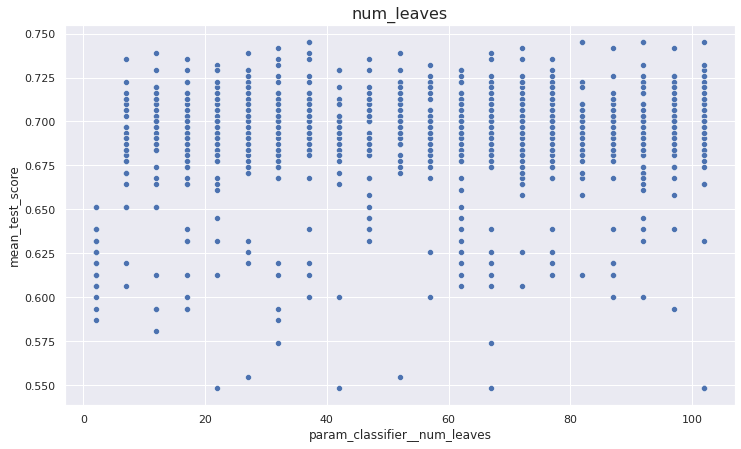

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


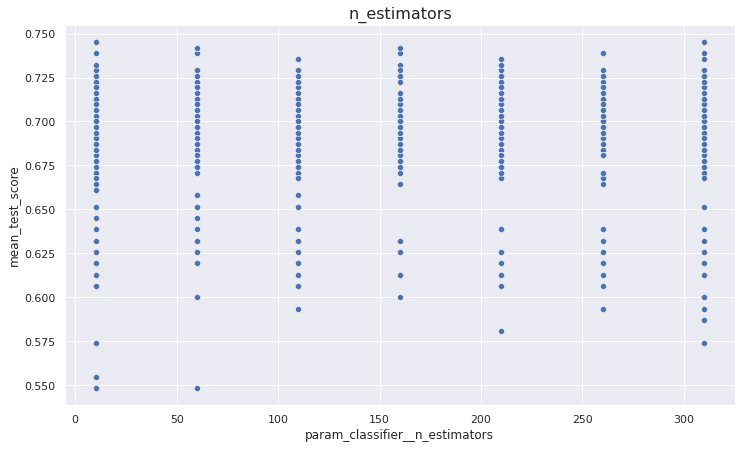

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


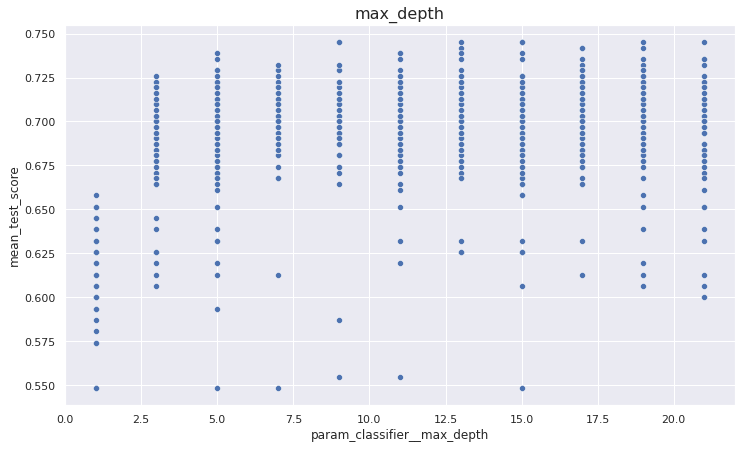

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


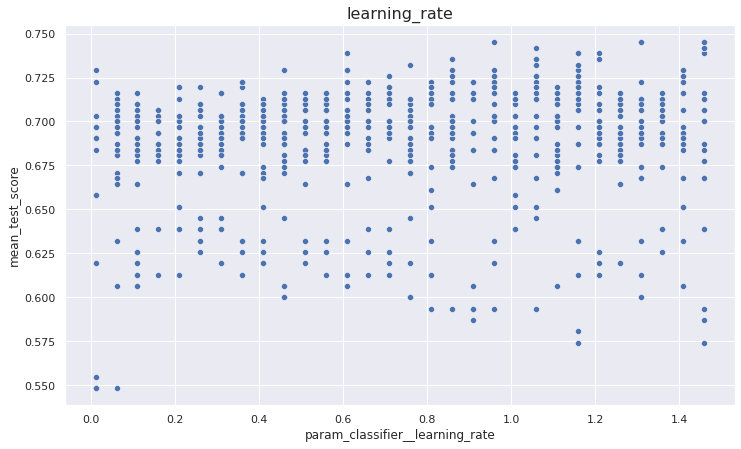

In [ ]:
results_ = results.loc[results['param_classifier'].apply(lambda x: type(x)==LGBMClassifier)]
for col in results_.columns:
  if 'param_classifier__' in col:
    sns.set( rc = {'figure.figsize' : ( 12, 7 ), 
                  'axes.labelsize' : 12 })
    plt.title(col.split('__')[1], size = 16)
    g = sns.scatterplot(results_[col], results_['mean_test_score'])
    # g.set(ylim=(0.515, 0.525))
    plt.show()

## Model Evaluation

In [91]:
model = Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=1.4600000000000002, max_depth=15,
                                n_estimators=310, num_leaves=82))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [92]:
print('Results of the Tuned Model:', pd.DataFrame(classification_report(y_test, y_pred>0.5, output_dict=True)), sep='\n')

Results of the Tuned Model:
                   0          1  accuracy  macro avg  weighted avg
precision   0.800000   0.842105  0.820513   0.821053      0.821592
recall      0.842105   0.800000  0.820513   0.821053      0.820513
f1-score    0.820513   0.820513  0.820513   0.820513      0.820513
support    19.000000  20.000000  0.820513  39.000000     39.000000


In [93]:
# save the model
model_path = 'activity_detection_model.pkl'
model_file = open(model_path, 'wb')
pickle.dump(model, model_file)
model_file.close()

In [ ]:
# TODO: handle sides issue
## option 1: balance sides of the photos
## option 2: pick side by visibility 

# TODO: add object at hand detection

## Model Explanation

In [94]:
feature_weights = eli5.explain_weights_df(model, feature_names=X_train.columns)
print('Results of the Tuned Model:', feature_weights, sep='\n')

Results of the Tuned Model:
          feature    weight
0       LEFT_KNEE  0.184390
1     RIGHT_ANKLE  0.156900
2      LEFT_ANKLE  0.132831
3      LEFT_ELBOW  0.111525
4     RIGHT_ELBOW  0.111486
5   LEFT_SHOULDER  0.103091
6  RIGHT_SHOULDER  0.077658
7        LEFT_HIP  0.051872
8      RIGHT_KNEE  0.048360
9       RIGHT_HIP  0.021889


## For Later

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Initialize the model
model = keras.Sequential()
# Add layers
model.add(layers.Dense(5, activation='softmax', input_dim=10))
model.add(layers.Dense(2, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))
model.add(layers.Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Fit the model
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4516


In [ ]:
pd.DataFrame(classification_report(y_test, y_pred>0.5, output_dict=True))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,accuracy,macro avg,weighted avg
precision,0.0,0.512821,0.512821,0.256410,0.262985
recall,0.0,1.000000,0.512821,0.500000,0.512821
f1-score,0.0,0.677966,0.512821,0.338983,0.347675
support,19.0,20.000000,0.512821,39.000000,39.000000
